In [18]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer
from datasets import Dataset, DatasetDict
from tqdm import tqdm
import wandb
import pandas as pd
import numpy as np

In [2]:
print(torch.__version__)
print("GPU available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0))


2.7.1+cu118
GPU available: True
GPU name: NVIDIA GeForce RTX 4060 Ti


In [4]:
train = pd.read_csv(r"D:\train.tsv", delimiter='\t',header=None)
dev = pd.read_csv(r"D:\dev.tsv", delimiter='\t', header=None)
test = pd.read_csv(r"D:\test.tsv", delimiter='\t', header=None)

columns = ['text', 'labels', 'id']

train.columns = columns
dev.columns = columns
test.columns = columns

In [5]:
train.drop('id', axis=1, inplace=True)
dev.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [6]:
# ===== 3) Mapping 28 → 7 labels =====
emotion_list = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion",
    "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment",
    "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness", "optimism",
    "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

ekman_mapping = {
    "anger": ["anger", "annoyance", "disapproval"],
    "disgust": ["disgust"],
    "fear": ["fear", "nervousness", "confusion"],
    "joy": ["admiration", "amusement", "approval", "caring", "desire", "excitement",
            "gratitude", "joy", "love", "optimism", "pride", "relief"],
    "sadness": ["sadness", "disappointment", "embarrassment", "grief", "remorse"],
    "surprise": ["surprise", "realization", "curiosity"],
    "neutral": ["neutral"]
}

ekman_to_index = {k: i for i, k in enumerate(ekman_mapping.keys())}

In [7]:
def map_labels(labels):
    new_id_label = []
    emotions = labels.split(',')
    for label in emotions:
        label = emotion_list[int(label)]
        new_label = [ekman_to_index[k] for k, v in ekman_mapping.items() if label in v]
        new_id_label.extend(new_label)
    return list(set(new_id_label))


In [ ]:
def encode_label(examples):
    return {'labels': [label2id[l] for l in examples['mapped_label']]}

In [8]:
train['new_labels'] = train['labels'].apply(map_labels)
dev['new_labels'] = dev['labels'].apply(map_labels)
test['new_labels'] = test['labels'].apply(map_labels)

In [9]:
mlb = MultiLabelBinarizer(classes=list(range(7)))
y_train = mlb.fit_transform(train['new_labels'])
y_dev = mlb.transform(dev['new_labels'])
y_test = mlb.transform(test['new_labels'])


In [10]:
train['labels'] = y_train.tolist()
dev['labels'] = y_dev.tolist()
test['labels'] = y_test.tolist()


In [11]:
train_ds = Dataset.from_pandas(train[['text', 'labels']])
dev_ds = Dataset.from_pandas(dev[['text', 'labels']])
test_ds = Dataset.from_pandas(test[['text', 'labels']])

dataset = DatasetDict({
    'train': train_ds,
    'validation': dev_ds,
    'test': test_ds
})


In [12]:
# ===== 4) Tokenize =====
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=False,
    revision="main",   # ép đúng nhánh model
)

def tokenize(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128,  # thêm dòng này để ép mọi chuỗi về 128 tokens
    )
tokenized_dataset = dataset.map(tokenize, batched=True)

c:\anaconda\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 5427/5427 [00:00<00:00, 12429.82 examples/s]


In [13]:
print(len(tokenized_dataset["train"][0]["input_ids"]))



128


In [14]:
from torch.utils.data import DataLoader
from dataclasses import dataclass
from typing import Any, Dict, List
import torch

@dataclass
class MultiLabelDataCollator:
    tokenizer: Any

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        # labels tách riêng
        labels = [f["labels"] for f in features]
        # chuẩn hóa input_ids & attention_mask bằng tokenizer
        batch = self.tokenizer.pad(
            [{k: v for k, v in f.items() if k != "labels"} for f in features],
            return_tensors="pt",
            padding="longest",
        )
        # thêm labels vào batch (chuyển thành tensor float cho BCEWithLogitsLoss)
        batch["labels"] = torch.tensor(labels, dtype=torch.float)
        return batch


In [15]:
data_collator = MultiLabelDataCollator(tokenizer)


keep_columns = ["input_ids", "attention_mask", "labels"]

train_loader = DataLoader(
    tokenized_dataset["train"].remove_columns(
        [col for col in tokenized_dataset["train"].column_names if col not in keep_columns]
    ),
    batch_size=16,
    shuffle=True,
    collate_fn=data_collator
)

val_loader = DataLoader(
    tokenized_dataset["validation"].remove_columns(
        [col for col in tokenized_dataset["validation"].column_names if col not in keep_columns]
    ),
    batch_size=16,
    collate_fn=data_collator
)


In [16]:
# ===== 6) Model & Optimizer =====

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=7,  # bạn đã chuẩn hóa 7 nhóm Ekman
    problem_type="multi_label_classification",  # rất quan trọng cho bài toán multi-label
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

c:\anaconda\envs\nlp\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\anaconda\envs\nlp\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
wandb.init(
    project="deberta-goemotions-7labels",
    name="deberta-v3-base-run1",
    config={
        "model": "microsoft/deberta-v3-base",
        "batch_size": 16,
        "lr": 2e-5,
        "epochs": 10,
    }
)

# ===== 7) Training loop =====

num_epochs = 10
threshold = 0.5  # threshold để cắt nhị phân multi-label

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)  # cần .float() cho BCE
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Train loss: {avg_train_loss:.4f}")

    # ===== Validation =====
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()  # lấy ground truth trước
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= threshold).astype(int)  # multi-label: sigmoid + threshold
            
            all_preds.append(preds)
            all_labels.append(labels)
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    macro_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    hamming = hamming_loss(all_labels, all_preds)
    subset_acc = accuracy_score(all_labels, all_preds)  # subset accuracy: tất cả nhãn phải khớp
    
    print(f"Epoch {epoch+1} - Val Macro F1: {macro_f1:.4f}, Hamming Loss: {hamming:.4f}, Subset Acc: {subset_acc:.4f}")
    
    # ===== Log lên wandb =====
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_macro_f1": macro_f1,
        "val_hamming_loss": hamming,
        "val_subset_acc": subset_acc,
    })
    
    # ===== Lưu model sau mỗi epoch =====
    checkpoint_name = f"deberta_goemotions_epoch{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_name)
    wandb.save(checkpoint_name)

wandb.finish()


Training Epoch 1: 100%|██████████| 2714/2714 [11:37<00:00,  3.89it/s]


Epoch 1 - Train loss: 0.2100


Validating: 100%|██████████| 340/340 [00:22<00:00, 15.39it/s]


Epoch 1 - Val Macro F1: 0.5827, Hamming Loss: 0.0891, Subset Acc: 0.6071


Training Epoch 2: 100%|██████████| 2714/2714 [19:38<00:00,  2.30it/s]


Epoch 2 - Train loss: 0.1860


Validating: 100%|██████████| 340/340 [00:30<00:00, 11.06it/s]


Epoch 2 - Val Macro F1: 0.5977, Hamming Loss: 0.0924, Subset Acc: 0.5958


Training Epoch 3: 100%|██████████| 2714/2714 [16:03<00:00,  2.82it/s]


Epoch 3 - Train loss: 0.1585


Validating: 100%|██████████| 340/340 [00:30<00:00, 11.33it/s]


Epoch 3 - Val Macro F1: 0.5987, Hamming Loss: 0.0959, Subset Acc: 0.6015


Training Epoch 4: 100%|██████████| 2714/2714 [14:24<00:00,  3.14it/s]


Epoch 4 - Train loss: 0.1301


Validating: 100%|██████████| 340/340 [00:20<00:00, 16.44it/s]


Epoch 4 - Val Macro F1: 0.5928, Hamming Loss: 0.0963, Subset Acc: 0.6104


Training Epoch 5: 100%|██████████| 2714/2714 [11:08<00:00,  4.06it/s]


Epoch 5 - Train loss: 0.1046


Validating: 100%|██████████| 340/340 [00:20<00:00, 16.73it/s]


Epoch 5 - Val Macro F1: 0.5868, Hamming Loss: 0.0993, Subset Acc: 0.5982


Training Epoch 6: 100%|██████████| 2714/2714 [10:58<00:00,  4.12it/s]


Epoch 6 - Train loss: 0.0856


Validating: 100%|██████████| 340/340 [00:19<00:00, 17.45it/s]


Epoch 6 - Val Macro F1: 0.5848, Hamming Loss: 0.1015, Subset Acc: 0.5881


Training Epoch 7: 100%|██████████| 2714/2714 [10:34<00:00,  4.28it/s]


Epoch 7 - Train loss: 0.0717


Validating: 100%|██████████| 340/340 [00:19<00:00, 17.40it/s]


Epoch 7 - Val Macro F1: 0.5714, Hamming Loss: 0.1041, Subset Acc: 0.5822


Training Epoch 8: 100%|██████████| 2714/2714 [10:33<00:00,  4.28it/s]


Epoch 8 - Train loss: 0.0610


Validating: 100%|██████████| 340/340 [00:19<00:00, 17.42it/s]


Epoch 8 - Val Macro F1: 0.5431, Hamming Loss: 0.1138, Subset Acc: 0.5509


Training Epoch 9: 100%|██████████| 2714/2714 [12:17<00:00,  3.68it/s]


Epoch 9 - Train loss: 0.0524


Validating: 100%|██████████| 340/340 [00:26<00:00, 12.90it/s]


Epoch 9 - Val Macro F1: 0.5691, Hamming Loss: 0.1050, Subset Acc: 0.5809


Training Epoch 10: 100%|██████████| 2714/2714 [14:26<00:00,  3.13it/s]


Epoch 10 - Train loss: 0.0457


Validating: 100%|██████████| 340/340 [00:23<00:00, 14.21it/s]


Epoch 10 - Val Macro F1: 0.5656, Hamming Loss: 0.1090, Subset Acc: 0.5645


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▅▄▃▂▂▁▁
val_hamming_loss,▁▂▃▃▄▅▅█▆▇
val_macro_f1,▆██▇▇▆▅▁▄▄
val_subset_acc,█▆▇█▇▅▅▁▅▃
epoch,10
train_loss,0.04572
val_hamming_loss,0.109
val_macro_f1,0.56562
val_subset_acc,0.5645


In [21]:
from transformers import AutoModelForSequenceClassification

# Giả sử bạn đã lưu weight ở 'deberta_goemotions_best.pth'
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=7,
    problem_type="multi_label_classification",
)
model.load_state_dict(torch.load(r"C:\Users\ADMIN\Downloads\deberta_goemotions_epoch10.pth", map_location="cpu"))
model.to(device)
model.eval()


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [22]:
test_loader = DataLoader(
    tokenized_dataset["test"].remove_columns(
        [col for col in tokenized_dataset["test"].column_names if col not in keep_columns]
    ),
    batch_size=16,
    collate_fn=data_collator,
)


In [23]:
all_test_preds = []
all_test_probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting Test Set"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()  # multi-label: dùng sigmoid

        preds = (probs >= 0.5).astype(int)

        all_test_probs.append(probs)
        all_test_preds.append(preds)

# Nối các batch lại
all_test_probs = np.vstack(all_test_probs)  # xác suất
all_test_preds = np.vstack(all_test_preds)  # nhãn nhị phân


Predicting Test Set: 100%|██████████| 340/340 [00:22<00:00, 15.07it/s]


In [25]:
ekman_labels = list(ekman_mapping.keys())  # danh sách nhãn theo thứ tự index 0-6

for i in range(10):
    predicted = [ekman_labels[j] for j, v in enumerate(all_test_preds[i]) if v == 1]
    probs_dict = {f"{ekman_labels[j]}_prob": all_test_probs[i, j] for j in range(len(ekman_labels))}
    print(f"Sample {i}:")
    print("  Predicted labels:", predicted)
    print("  Probabilities:", probs_dict)
    print("  ----------------------------")


Sample 0:
  Predicted labels: ['joy', 'sadness']
  Probabilities: {'anger_prob': np.float32(0.0007615878), 'disgust_prob': np.float32(3.7126436e-05), 'fear_prob': np.float32(0.00055513193), 'joy_prob': np.float32(0.98823816), 'sadness_prob': np.float32(0.6338523), 'surprise_prob': np.float32(0.00024968086), 'neutral_prob': np.float32(0.0006867812)}
  ----------------------------
Sample 1:
  Predicted labels: ['joy']
  Probabilities: {'anger_prob': np.float32(0.15635367), 'disgust_prob': np.float32(0.17629749), 'fear_prob': np.float32(0.001413328), 'joy_prob': np.float32(0.99580115), 'sadness_prob': np.float32(0.0034380143), 'surprise_prob': np.float32(0.00028501858), 'neutral_prob': np.float32(0.00021712975)}
  ----------------------------
Sample 2:
  Predicted labels: ['joy']
  Probabilities: {'anger_prob': np.float32(2.4367886e-05), 'disgust_prob': np.float32(9.672468e-07), 'fear_prob': np.float32(5.237669e-05), 'joy_prob': np.float32(0.99968386), 'sadness_prob': np.float32(2.6623224

In [26]:
import pandas as pd

results = []
for i in range(len(all_test_preds)):
    preds = [ekman_labels[j] for j, v in enumerate(all_test_preds[i]) if v == 1]
    entry = {"sample_idx": i, "predicted_labels": preds}
    for j, label in enumerate(ekman_labels):
        entry[f"{label}_prob"] = all_test_probs[i, j]
    results.append(entry)

df_results = pd.DataFrame(results)
df_results.to_csv("test_predictions.csv", index=False)
print("✅ Đã lưu kết quả dự đoán vào test_predictions.csv")


✅ Đã lưu kết quả dự đoán vào test_predictions.csv


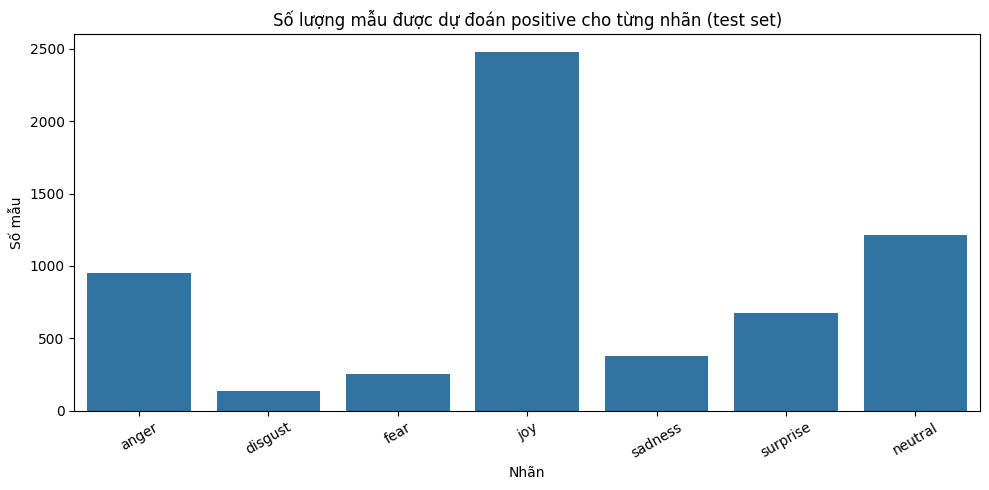

✅ Đã lưu biểu đồ phân bố label vào label_distribution.png


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Đếm tổng số lần mỗi nhãn được dự đoán 1
label_counts = np.sum(all_test_preds, axis=0)
plt.figure(figsize=(10, 5))
sns.barplot(x=ekman_labels, y=label_counts)
plt.title("Số lượng mẫu được dự đoán positive cho từng nhãn (test set)")
plt.ylabel("Số mẫu")
plt.xlabel("Nhãn")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("label_distribution.png")
plt.show()
print("✅ Đã lưu biểu đồ phân bố label vào label_distribution.png")
